In [36]:
from matplotlib import pyplot as plt
import sounddevice as sd
import soundfile as sf
from scipy.io.wavfile import write
from scipy.signal import fftconvolve
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image



---

# 1


## a)


In [23]:

filename = 'StarWars60.wav'
# Extract data and sampling rate from file
data60, fs = sf.read(filename, dtype='float32')  
n_amostras = int(10*fs)
data_10s = data60[:n_amostras]
# sd.play(data_10s, fs)
# status = sd.wait()  # Wait until file is done playing


## b)

In [52]:
def espectro_audio(filepath):
    data, fs = sf.read(filepath, dtype='float32')  

    # Aplica a Transformada de Fourier
    fft_result = np.fft.fft(data)
    fft_freqs = np.fft.fftfreq(len(data), d=1/fs)

    # Pega apenas a parte positiva do espectro
    positive_freqs = fft_freqs[:len(fft_freqs)//2]
    positive_magnitude = np.abs(fft_result[:len(fft_result)//2])

    # Plota o espectro
    plt.figure(figsize=(12, 4))
    plt.plot(positive_freqs, positive_magnitude)
    plt.title('Espectro do Áudio (10 segundos)')
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


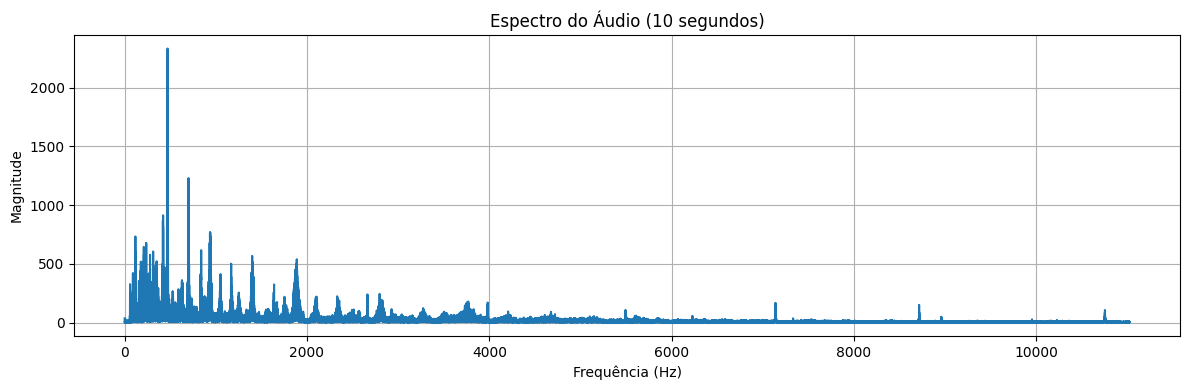

In [55]:
espectro_audio('StarWars10.wav')

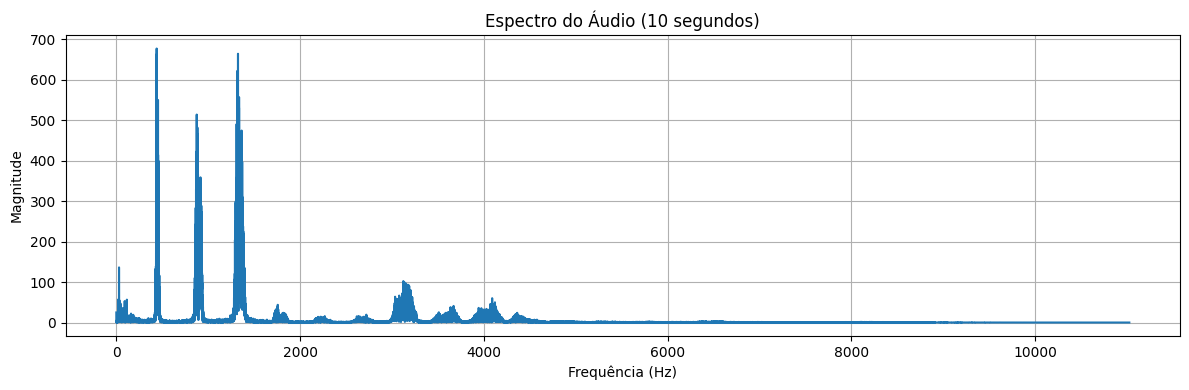

In [56]:
espectro_audio('WomanSinging.wav')


---

# 2


## a)

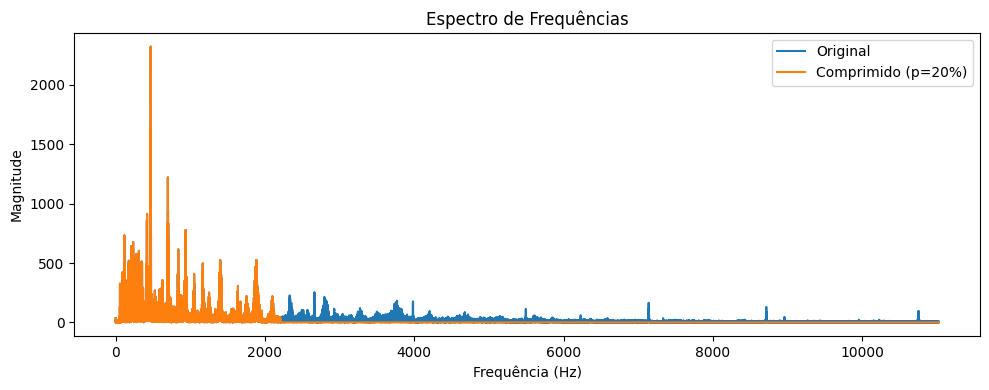

In [25]:
# Aplica a Transformada de Fourier
fft_data = np.fft.fft(data_10s)

# Cria array de frequências
freqs = np.fft.fftfreq(len(data_10s), d=1/fs)

# Parâmetro de compressão: fração p de frequências baixas a manter
p = 0.2  # 20% das frequências baixas

# Define o número de componentes a preservar
n = len(fft_data)
keep = int(p * n // 2)

# Zera as frequências altas (espelhadas também!)
fft_data_compressed = np.zeros_like(fft_data)
fft_data_compressed[:keep] = fft_data[:keep]
fft_data_compressed[-keep:] = fft_data[-keep:]

# Reconstrói o sinal via FFT inversa
compressed_data = np.fft.ifft(fft_data_compressed).real

# Normaliza para não distorcer
compressed_data = compressed_data / np.max(np.abs(compressed_data))

# Salva o novo áudio
sf.write("audio_comprimido.wav", compressed_data, fs)

# Opcional: visualizar espectro original vs. comprimido
plt.figure(figsize=(10, 4))
plt.plot(freqs[:n//2], np.abs(fft_data[:n//2]), label='Original')
plt.plot(freqs[:n//2], np.abs(fft_data_compressed[:n//2]), label=f'Comprimido (p={p*100:.0f}%)')
plt.xlabel("Frequência (Hz)")
plt.ylabel("Magnitude")
plt.title("Espectro de Frequências")
plt.legend()
plt.tight_layout()
plt.show()

## b)
- Diferença Perceptiva:
    - É observado que a remoção das frequências altas causa a perda de nitidez do áudio.
    - O áudio resultantesoa mais abafado, como se você o ouvisse por um telefone ou com um pano em cima do alto-falante.
    - As frequências baixas (graves) são preservadas, mantendo o ritmo, mas perde-se harmônicos e detalhes.
- Impacto da compressão:
    - Reduz a quantidade de informação.
    - É um tipo de compressão com perda, pois os dados são descartados e não podem ser recuperados.
    - Útil para reduzir tamanhoou fazer filtragem (ex: remover ruído agudo).


---

# 3

## a)

In [34]:
# Carrega o áudio 
file = "Espirro"
data, fs = sf.read(f"{file}.wav")

# Se for estéreo, converte para mono
if data.ndim > 1:
    data = data[:, 0]

# Cria um filtro com atraso de 0.5 segundos
delay = 0.5  # em segundos
delay_samples = int(fs * delay)

# Filtro do tipo [1, 0, 0, ..., α] — eco após 0.5s
alpha = 0.1  # intensidade do eco
impulse_response = np.zeros(delay_samples + 1)
impulse_response[0] = 1.0
impulse_response[-1] = alpha

# Convolução via FFT
echoed = fftconvolve(data, impulse_response, mode='full')

# Normaliza
echoed /= np.max(np.abs(echoed))

# Salva
sf.write(f"{file}_eco.wav", echoed, fs)


## b)

In [35]:
# Parâmetros do reverb
num_echoes = 10
interval_ms = 40  # espaço entre ecos em milissegundos
interval_samples = int(fs * interval_ms / 1000)
decay = 0.5  # decaimento exponencial da amplitude

# Cria a resposta ao impulso (filtro de reverb)
impulse_response = np.zeros(num_echoes * interval_samples + 1)
for i in range(num_echoes):
    impulse_response[i * interval_samples] = decay ** i  # decai exponencialmente

# Convolução via FFT
reverbed = fftconvolve(data, impulse_response, mode='full')

# Normaliza
reverbed /= np.max(np.abs(reverbed))

# Salva
sf.write(f"{file}_reverb.wav", reverbed, fs)



---

# 4


## a)

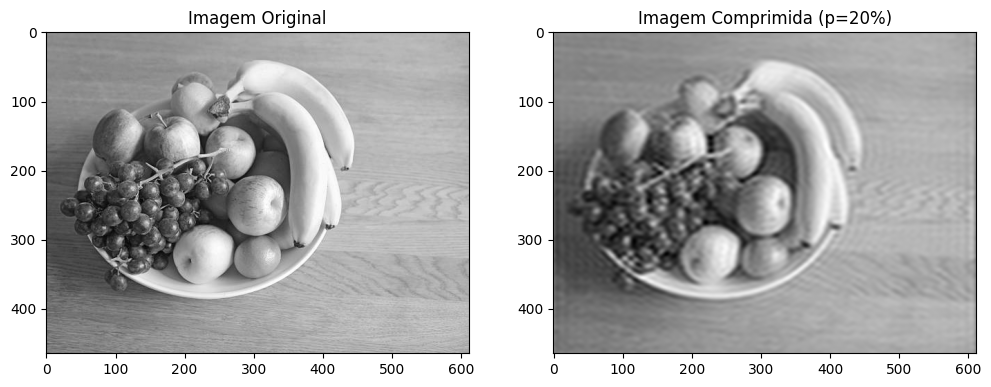

In [43]:
# Carrega a imagem em escala de cinza
img = Image.open('frutas.jpg').convert('L')
img_array = np.array(img)

# Transformada de Fourier 2D
f = np.fft.fft2(img_array)
fshift = np.fft.fftshift(f)  # centraliza o zero da FFT

# Cria filtro passa-baixa
rows, cols = img_array.shape
crow, ccol = rows // 2, cols // 2

p = 0.2 # 20% das frequências baixas serão mantidas
mask = np.zeros_like(fshift)
r = int(p * min(rows, cols) / 2)

mask[crow - r:crow + r, ccol - r:ccol + r] = 1
fshift_filtered = fshift * mask

# Reconstrói a imagem
f_ishift = np.fft.ifftshift(fshift_filtered)
img_back = np.fft.ifft2(f_ishift).real

# Plota resultado
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Imagem Original")
plt.imshow(img_array, cmap='gray')

plt.subplot(1, 2, 2)
plt.title(f"Imagem Comprimida (p={p*100:.0f}%)")
plt.imshow(img_back, cmap='gray')
plt.show()


## b)
- Descrição do efeito do filtro passa-baixa
    - A imagem resultante fica embaçada, com menos detalhes finos.
    - O contorno dos objetos ainda é visível, mas teturas e nitidez se perdem.
    - Se 'p' for muito baixo, a imagem fica quase irreconhecível, parecendo uma névoa.

## c)


- Descrição do efeito do filtro passa-alta
    - A imagem mostra somente o contorno e bordas
    - Perde-se o contraste suave e as regiões uniformes da imagem
    - Parece uma imagem de detecção de bordas (parecida com Sobel e Canny)

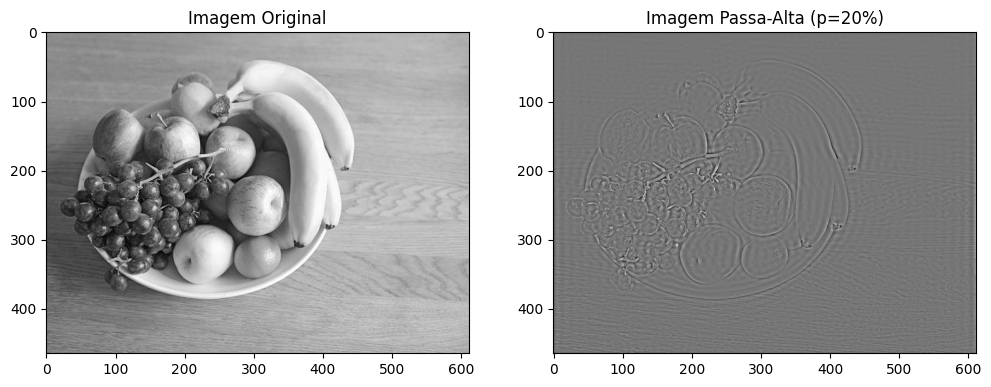

In [41]:
# Filtro passa-alta: remove frequências baixas
mask_high = 1 - mask
fshift_high = fshift * mask_high

# Reconstrói
f_ishift_high = np.fft.ifftshift(fshift_high)
img_high = np.fft.ifft2(f_ishift_high).real

# Plota resultado
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Imagem Original")
plt.imshow(img_array, cmap='gray')

plt.subplot(1, 2, 2)
plt.title(f"Imagem Passa-Alta (p={p*100:.0f}%)")
plt.imshow(img_high, cmap='gray')
plt.show()



---

# 5


## Enunciado

Seja uma função $T : \mathbb{R}^n \rightarrow \mathbb{R}^n $, tal que:
$$
T(u) = h \circledast u
$$
onde $ \circledast $ representa a **convolução circular** com algum vetor $ h \in \mathbb{R}^n $.

Deseja-se mostrar que:
$$
h = T(\delta)
$$
onde $ \delta = (1, 0, 0, \dots, 0) \in \mathbb{R}^n $, ou seja, o **vetor impulso unitário**.


## Intuição

A convolução circular com o vetor impulso $ \delta $ retorna o próprio vetor convoluído. Isso se deve ao fato de $ \delta $ ser o elemento neutro da convolução circular, assim como 1 é o neutro da multiplicação.


## Demonstração

Sabemos que:
$$
T(u) = h \circledast u
$$

Aplicando $ T $ ao vetor impulso $ \delta $:
$$
T(\delta) = h \circledast \delta = h
$$

Portanto:
$$
\boxed{h = T(\delta)}
$$



---

# 6

## Enunciado

Seja um filtro $ F: \mathbb{R}^n \rightarrow \mathbb{R}^n $, com as propriedades:

1. **Linearidade**:  
   $$
   F(au + bv) = aF(u) + bF(v)
   $$

2. **Invariância por translação circular**:  
   Se $ F(u) = v $, então  
   $$
   F(u(k - t)) = v(k - t)
   $$  
   ou seja, deslocar a entrada circularmente por $ t \in \mathbb{Z} $ desloca a saída da mesma forma.


## Intuição

Estas duas propriedades — **linearidade** e **invariância por translação circular** — caracterizam filtros que **podem ser representados como convoluções circulares**.

Vamos mostrar que, se um filtro $ F $ satisfaz ambas as propriedades, então ele **necessariamente** pode ser descrito como:

$$
F(u) = h \circledast u
$$

para algum vetor $ h \in \mathbb{R}^n $, onde $ \circledast $ é a **convolução circular**.


## Demonstração

Considere a base canônica $ \delta^{(j)} $, onde:
$$
\delta^{(j)}_k =
\begin{cases}
1, & \text{se } k = j \\
0, & \text{caso contrário}
\end{cases}
$$

Cada vetor $ u \in \mathbb{R}^n $ pode ser escrito como combinação linear:

$$
u = \sum_{j=0}^{n-1} u_j \delta^{(j)}
$$

Aplicando o filtro $ F $, e usando a **linearidade**:

$$
F(u) = \sum_{j=0}^{n-1} u_j F(\delta^{(j)})
$$

Agora, note que $ \delta^{(j)} $ é uma translação circular de $ \delta^{(0)} $:
$$
\delta^{(j)} = \delta^{(0)}(k - j)
$$

Então, pela **invariância por translação**:
$$
F(\delta^{(j)}) = F(\delta^{(0)}(k - j)) = h(k - j)
$$
onde $ h = F(\delta^{(0)}) $

Logo:
$$
F(u) = \sum_{j=0}^{n-1} u_j h(k - j) = h \circledast u
$$



## Conclusão

Se um filtro $ F $ é **linear** e **invariante por translação circular**, então ele é necessariamente uma **convolução circular** com algum vetor $ h $:

$$
\boxed{F(u) = h \circledast u}
$$

Ou seja, **filtros lineares e invariantes por translação circular são exatamente as convoluções circulares**.
